In [1]:
import torch
from PIL import Image
from tokenizer import Tokenizer
from matplotlib import pyplot as plt
import torchvision
from model import Foundation


/home/starsystem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-6
VOCAB_SIZE = 128
EMBD_SIZE = 256
NUM_HEADS = 16
NUM_BLOCKS = 8
DROPOUT = 0.1
IMG_SIZE = 256
NUM_WORKERS = 2

WARMUP_STEPS = 400


CSV_DIR = "/home/starsystem/Documents/SceneUnderstanding/models/"
MODEL_SAVE_DIR = "/home/starsystem/Documents/SceneUnderstanding/models/"
MODEL_SAVE_NAME = "Foundation.pt"
CSV_NAME = "Foundation.csv"

In [3]:
print(f"Using PyTorch version {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device {device}")
torch.set_float32_matmul_precision('high')
torch._dynamo.config.suppress_errors = True

Using PyTorch version 2.1.0.dev20230829+cu118
Using device cuda


In [4]:
tokenizer = Tokenizer()
tokenizer.load("tokenizer2.pkl")

In [5]:
# model = Foundation(num_blocks = NUM_BLOCKS,
#                    num_heads = NUM_HEADS, 
#                    unk_char = tokenizer.char_to_idx["[UNK]"],
#                    vocab_size=VOCAB_SIZE, 
#                    embd_size=EMBD_SIZE, 
#                    dropout = DROPOUT).to(device)
model = torch.load(MODEL_SAVE_DIR + MODEL_SAVE_NAME)

In [6]:
# model = torch.compile(model)
img_processor = img_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
])

In [7]:
def test_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
            img = img.convert('RGB')
    img = img_processor(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    text = [tokenizer.char_to_idx["[START]"]]
    text = torch.tensor(text).to(torch.int64).to(device)
# print(text.shape)

    model.eval()
    with torch.no_grad():
        i = 0
        while True:
            output = model((text.unsqueeze(0), img))
            output = output.argmax(dim = -1)
            text = torch.concat([text, output[-1][-1].unsqueeze(0)], dim = -1)
        # print(text)
            if output[0][-1] == tokenizer.char_to_idx["[END]"]:
                break
            i += 1
            if i > 100:
                break
    print(f"The string is {tokenizer.decode(text[1:-1].tolist())}")
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()

The string is A plate of food that is on a table.


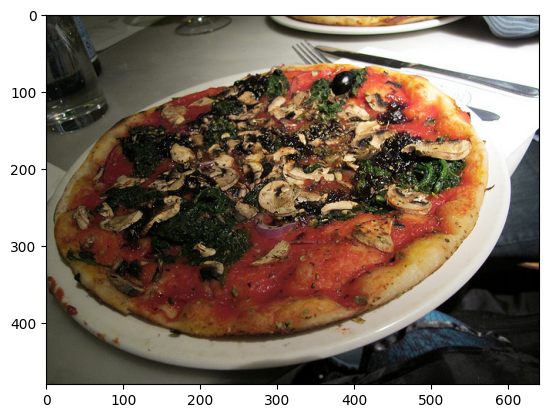

In [22]:
test_image("/home/starsystem/Documents/SceneUnderstanding/dataset(coco)/val2014/COCO_val2014_000000003192.jpg")